In [ ]:
! pip install prophet

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import necessary libraries


from prophet import Prophet


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error,mean_absolute_error
from tensorflow.keras.models import load_model


from datetime import datetime, timedelta

import warnings
warnings.filterwarnings('ignore')

# Enable inline plotting for Jupyter Notebook
%matplotlib inline

In [ ]:
dfa = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/well_production/data/Copy of Volve production data.xlsx')
dfa.head()

,DATEPRD,WELL_BORE_CODE,NPD_WELL_BORE_CODE,NPD_WELL_BORE_NAME,NPD_FIELD_CODE,NPD_FIELD_NAME,NPD_FACILITY_CODE,NPD_FACILITY_NAME,ON_STREAM_HRS,AVG_DOWNHOLE_PRESSURE,...,AVG_CHOKE_UOM,AVG_WHP_P,AVG_WHT_P,DP_CHOKE_SIZE,BORE_OIL_VOL,BORE_GAS_VOL,BORE_WAT_VOL,BORE_WI_VOL,FLOW_KIND,WELL_TYPE
0,2014-04-07,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,0.00000,...,%,0.00000,0.00000,0.00000,0.0,0.0,0.0,NaN,production,WI
1,2014-04-08,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,NaN,...,%,0.00000,0.00000,0.00000,0.0,0.0,0.0,NaN,production,OP
2,2014-04-09,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,NaN,...,%,0.00000,0.00000,0.00000,0.0,0.0,0.0,NaN,production,OP
3,2014-04-10,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,NaN,...,%,0.00000,0.00000,0.00000,0.0,0.0,0.0,NaN,production,OP
4,2014-04-11,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,310.37614,...,%,33.09788,10.47992,33.07195,0.0,0.0,0.0,NaN,production,OP


In [ ]:
df = dfa.copy()
# Select relevant columns
df = df[['DATEPRD','NPD_WELL_BORE_NAME','BORE_OIL_VOL']]

# Rename Columns to more appropriate names
df.rename(columns={'DATEPRD': 'Date',
                   'NPD_WELL_BORE_NAME': 'WellID',
                   'BORE_OIL_VOL': 'Production',
                   }, inplace=True)
df.head()

,Date,WellID,Production
0,2014-04-07,15/9-F-1 C,0.0
1,2014-04-08,15/9-F-1 C,0.0
2,2014-04-09,15/9-F-1 C,0.0
3,2014-04-10,15/9-F-1 C,0.0
4,2014-04-11,15/9-F-1 C,0.0


In [ ]:
# Convert the 'DateColumn' to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Display the DataFrame with the updated column type
print(df.dtypes)

Date          datetime64[ns]
WellID                object
Production           float64
dtype: object


In [ ]:
# Make Date the index column
df.set_index('Date', inplace=True)

# Sort by date
df.sort_values(by='Date', inplace=True)

In [ ]:
df1 = df.copy()
df1 = df1[df1['WellID'] == '15/9-F-14']
df1.head()

,WellID,Production
Date,,
2008-02-12,15/9-F-14,0.0
2008-02-13,15/9-F-14,0.0
2008-02-14,15/9-F-14,0.0
2008-02-15,15/9-F-14,0.0
2008-02-16,15/9-F-14,0.0


In [ ]:
# Feature engineering
df1['Year'] = df1.index.year
df1['Month'] = df1.index.month
df1['Day'] = df1.index.day

# Remove the WellID column
df1.drop(columns=['WellID'], inplace=True)

# Filter off some unwanted data
df1 = df1[(df1['Year'] <= 2014)&(df1['Production'] != 0)]

df1.head()

,Production,Year,Month,Day
Date,,,,
2008-07-13,1735.26,2008,7,13
2008-07-14,592.36,2008,7,14
2008-07-15,2532.21,2008,7,15
2008-07-16,3030.71,2008,7,16
2008-07-17,3288.08,2008,7,17


In [ ]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df1['Production'].values.reshape(-1, 1))
scaled_data

array([[0.30690399],
       [0.10426466],
       [0.44820543],
       ...,
       [0.05113589],
       [0.06591408],
       [0.06197795]])

In [ ]:
# Prepare the data for Prophet
df_prophet = df1.reset_index()[['Date', 'Production']]
df_prophet.columns = ['ds', 'y']
df_prophet.head()

,ds,y
0,2008-07-13,1735.26
1,2008-07-14,592.36
2,2008-07-15,2532.21
3,2008-07-16,3030.71
4,2008-07-17,3288.08


In [ ]:
# Train-test split
split_index = int(len(df_prophet) * 0.8)
train_df = df_prophet.iloc[:split_index]
test_df = df_prophet.iloc[split_index:]

In [ ]:
# Initialize and fit the Prophet model
model = Prophet()
model.fit(train_df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpo1zij2pp/krb4_wjp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpo1zij2pp/zuplfflg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56191', 'data', 'file=/tmp/tmpo1zij2pp/krb4_wjp.json', 'init=/tmp/tmpo1zij2pp/zuplfflg.json', 'output', 'file=/tmp/tmpo1zij2pp/prophet_modelq7x2487_/prophet_model-20240718152218.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:22:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:22:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
# Make future DataFrame for predictions
future = model.make_future_dataframe(periods=len(test_df))
forecast = model.predict(future)

In [ ]:
# Extract the predictions
train_predict = forecast.iloc[:split_index]['yhat']
test_predict = forecast.iloc[split_index:]['yhat']
test_actual = test_df['y'].values

# Calculate evaluation metrics
mae = mean_absolute_error(test_actual, test_predict)
mse = mean_squared_error(test_actual, test_predict)
rmse = np.sqrt(mse)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

Mean Absolute Error (MAE): 202.2529597226919
Mean Squared Error (MSE): 70248.34280903936
Root Mean Squared Error (RMSE): 265.04403937655223


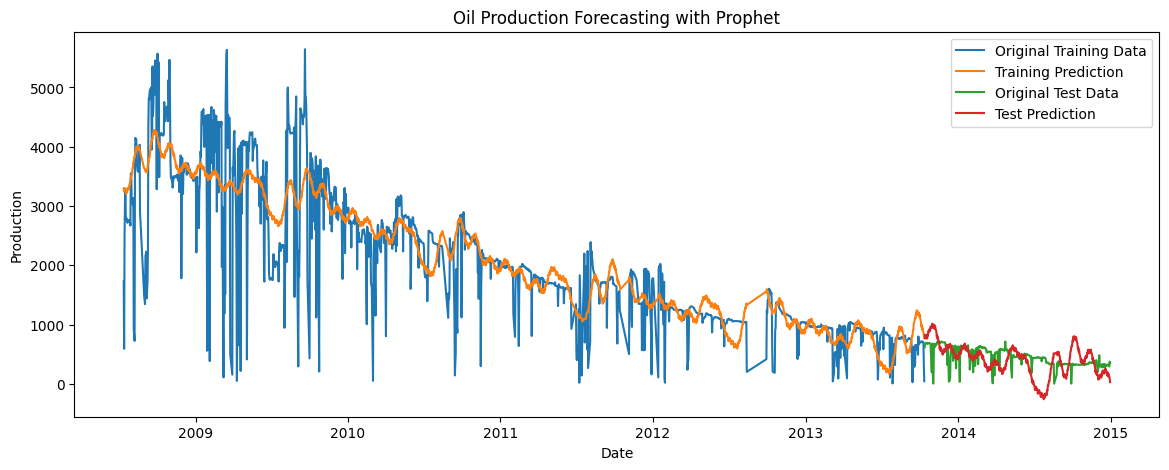

In [ ]:
# Plot the results
plt.figure(figsize=(14, 5))

# Plot training data
plt.plot(train_df['ds'], train_df['y'], label='Original Training Data')
plt.plot(train_df['ds'], train_predict, label='Training Prediction')

# Plot testing data
plt.plot(test_df['ds'], test_df['y'], label='Original Test Data')
plt.plot(test_df['ds'], test_predict, label='Test Prediction')

plt.title('Oil Production Forecasting with Prophet')
plt.xlabel('Date')
plt.ylabel('Production')
plt.legend()
plt.show()

In [ ]:
import pickle

model.save('/content/drive/MyDrive/Colab Notebooks/well_production/models/profet_model.h5')


# Load the model using load_model
model2_loaded = load_model('/content/drive/MyDrive/Colab Notebooks/well_production/models/profet_model.h5')

AttributeError: 'Prophet' object has no attribute 'save'